In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch

import numpy as np
import librosa
import IPython.display as ipd
from matplotlib import pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
from birds_analysis import analyze_audio, plot_librosa_stft, get_class_dataset, sample_audio_clip, multiclass_metrics, get_F1_micro, sample_audio_clip
from birds_utils import Dataset, get_audio_chunk, get_pytorch_model, validate_model_acc_loss, validate_model_loss_detail, get_pytorch_model_all_conv, validate, multilabel_metrics, get_bin_audio

In [17]:
window_size = 1024
sr = 22050

n_classes = 264
train_files = np.load(f'train_files_{sr}_{n_classes}_librosa.npy')
train_labels = np.load(f'train_labels_{sr}_{n_classes}_librosa.npy')
val_files = np.load(f'val_files_{sr}_{n_classes}_librosa.npy')
val_labels = np.load(f'val_labels_{sr}_{n_classes}_librosa.npy')
classes = np.load(f'./models/classes_{n_classes}.npy')
file_stats = np.load('files_std_data_librosa.npy', allow_pickle=True).item()

In [5]:
params = {'batch_size': 16,
          'shuffle': True,
          'num_workers': 1}

min_std = 0.5
duration = 5

In [6]:
saved_weights = './models/model_ambient_librosa_264_0.677.pth'


window_size = 1024
model = get_pytorch_model_all_conv(window_size, resnet='resnet18', pretrained=True, n_classes=n_classes, init_fourier=True, train_fourier=False).to(device)
state_dict = torch.load(saved_weights, map_location=torch.device('cpu'))

model.load_state_dict(state_dict)
_ = model.eval()

Using cache found in /Users/julian/.cache/torch/hub/pytorch_vision_v0.6.0


In [250]:
def get_cutted_acc(model, audio_sample, classes, fr, to, sr=22050):
    classes = np.array(classes)
#     t = np.linspace(0, len(audio_sample))
    audio_fraction = audio_sample[int(fr*sr):int(to*sr)]
    x_spec_conv, y_pred_conv = model(torch.tensor(audio_fraction.reshape(1, 1, -1)).float().to(device))

    y_pred_conv_softmax = torch.sigmoid(y_pred_conv)
    x_spec, y_pred = model(torch.tensor(audio_sample.reshape(1, 1, -1)).float().to(device))
    y_pred_softmax = torch.sigmoid(y_pred)
    idxs_conv = np.argsort(y_pred_conv_softmax.detach().numpy())[0][::-1]
    print('Recorte: ', classes[idxs_conv][:2] , y_pred_conv_softmax.detach().numpy()[0][idxs_conv][:2])
    
    idxs = np.argsort(y_pred_softmax.detach().numpy())[0][::-1]

    plt.imshow(np.flipud(x_spec_conv.cpu().squeeze(0).detach()), cmap='gray')
    plt.show()
    print('Toda:', classes[idxs][:2], y_pred_softmax.detach().numpy()[0][idxs][:2])
    plt.imshow(np.flipud(x_spec.cpu().squeeze(0).detach()), cmap='gray')
    plt.show()

In [393]:
def get_combined_f1(model, audio_1, audio_2, classes, sr=22050):
    classes = np.array(classes)

    
    x_spec_conv_1, y_pred_conv_1 = model(torch.tensor(audio_1.reshape(1, 1, -1)).float().to(device))
    y_pred_1 = torch.sigmoid(y_pred_conv_1)
    
    x_spec_conv_2, y_pred_conv_2 = model(torch.tensor(audio_2.reshape(1, 1, -1)).float().to(device))
    y_pred_2 = torch.sigmoid(y_pred_conv_2)
    
    x_spec_conv_3, y_pred_conv_3 = model(torch.tensor((audio_1 + audio_2).reshape(1, 1, -1)).float().to(device))
    y_pred_3 = torch.sigmoid(y_pred_conv_3)
    
    
    idxs_1 = np.argsort(y_pred_1.detach().numpy())[0][::-1]
    
    idxs_2 = np.argsort(y_pred_2.detach().numpy())[0][::-1]
    
    idxs_3 = np.argsort(y_pred_3.detach().numpy())[0][::-1]
    
    f, ax = plt.subplots(1, 3, figsize=(20, 4))
    
    ax[0].imshow(np.flipud(x_spec_conv_1.cpu().squeeze(0).detach()), cmap='gray')
    ax[0].set_title(f'{list(zip(classes[idxs_1][:2], y_pred_1.detach().numpy()[0][idxs_1][:2]))}')
    ax[1].imshow(np.flipud(x_spec_conv_2.cpu().squeeze(0).detach()), cmap='gray')
    ax[1].set_title(f'{list(zip(classes[idxs_2][:2], y_pred_2.detach().numpy()[0][idxs_2][:2]))}')
    ax[2].imshow(np.flipud(x_spec_conv_3.cpu().squeeze(0).detach()), cmap='gray')
    ax[2].set_title(f'COMB: {list(zip(classes[idxs_3][:2], y_pred_3.detach().numpy()[0][idxs_3][:2]))}')
    plt.show()

In [414]:
# 0 y 200 funcionan bien juntos
# 0 y 100 gana 0
# 100 y 200 gana 200
file_1 = val_files[0]
file_2 = val_files[200]
print(file_1, file_2)

./dataset/bin_22050_librosa/aldfly/XC302253.mp3.bin ./dataset/bin_22050_librosa/barswa/XC394892.mp3.bin


In [417]:
# audio_1 = get_bin_audio(file_1)[int(1.5*sr):int(2.5*sr)]
# audio_2 = get_bin_audio(file_2)[0:1*sr]

audio_1 = get_bin_audio(file_1)[int(0*sr):int(5*sr)]
audio_2 = get_bin_audio(file_2)[0:int(5*sr)]
print(audio_1.std(), audio_2.std())

1.083130760368234 0.9231505869308686


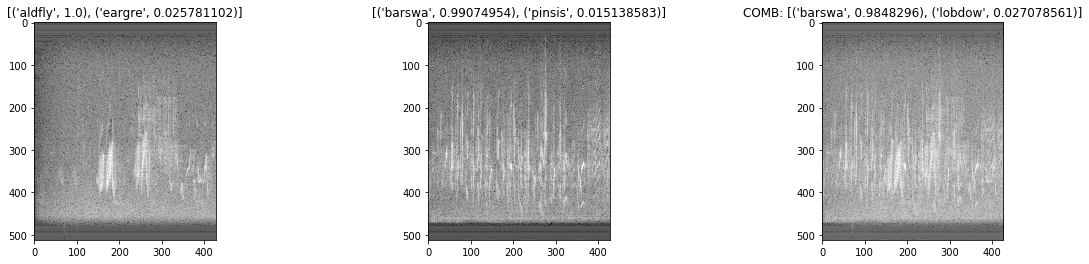

In [418]:
get_combined_f1(model, audio_1, audio_2, classes)

Recorte:  ['aldfly' 'eargre'] [1.         0.62689006]


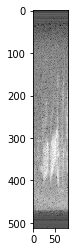

Toda: ['aldfly' 'barswa'] [0.98021024 0.9507262 ]


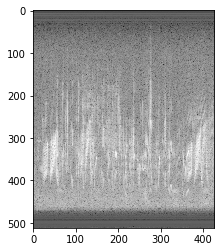

In [333]:
# 1.5, 2.5
# 0, 1
get_cutted_acc(model, audio_concat_1, classes, 0., 1)
ipd.Audio(audio_concat_1, rate=sr)